### Importing libraries

In [11]:
import pandas as pd
import numpy as np
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns

### Loading the 3 CSV files into Pandas DataFrame

In [3]:
customers = pd.read_csv("/Users/oluwaseyi/Downloads/Analytics Technical Case -  Hugh's Organics/Data/Cust_dim_table.csv")
products = pd.read_csv("/Users/oluwaseyi/Downloads/Analytics Technical Case -  Hugh's Organics/Data/Prod_dim_table.csv")
sales = pd.read_csv("/Users/oluwaseyi/Downloads/Analytics Technical Case -  Hugh's Organics/Data/Sales_fact_final.csv")
                       

### To use SQL, I need to create a SQLite Database in this notebook

In [4]:
conn = sqlite3.connect(":memory:")

### Loading the DataFrames into SQLite tables

In [5]:
customers.to_sql("customers", conn, index=False, if_exists="replace")
products.to_sql ("products", conn, index=False, if_exists="replace")
sales.to_sql("sales", conn, index=False, if_exists="replace")

3159580

### Commencing queries

### Basket Penetration and Revenue Penetration:
#### First Step: Count the total baskets and loyalty baskets and then calculate Total Spend and Loyalty Spend

#### 2nd Step: Using CTE, I will use the last result to calculate the percentage basket and revenue penetration

In [6]:
query = """

WITH loyalty_calculation AS (
    SELECT 
        COUNT(DISTINCT basket_id) AS total_baskets,  -- Total transactions
        COUNT(DISTINCT CASE WHEN cust_code IS NOT NULL THEN basket_id END) AS loyalty_baskets, -- Loyalty transactions
        SUM(spend) AS total_spend,  -- Total revenue
        SUM(CASE WHEN cust_code IS NOT NULL THEN spend ELSE 0 END) AS loyalty_spend -- Loyalty revenue
    FROM sales
    WHERE shop_date BETWEEN '2007-01-01' AND '2007-12-31'   -- Filter for 2007
)


SELECT *,
    ROUND((CAST(loyalty_baskets AS FLOAT)/ total_baskets) * 100,2) AS basket_penetration,
    ROUND((CAST(loyalty_spend AS FLOAT)/ total_spend) * 100,2) AS revenue_penetration
FROM loyalty_calculation;

             """

query_result = pd.read_sql_query(query,conn)
query_result 

,total_baskets,loyalty_baskets,total_spend,loyalty_spend,basket_penetration,revenue_penetration
0,220618,175467,2.705653e+06,2.170421e+06,79.53,80.22


### Comparing the percentage of penetration to the industry benchmarks:
#### Analysis results: 
- Basket Penetration: 79.53%
- Revenue Penetration: 80.22%
#### Industry Benchmarks:
- Basket Penetration Benchmark: 60%
- Revenue Penetration Benchmark: 90%
#### Analysis and Observations:
-  Basket Penetration (79.53%) vs. Benchmark (60%):
Above the benchmark: The loyalty program is performing exceptionally well in terms of basket penetration.
This indicates strong customer adoption and engagement, as loyalty members are generating a significant proportion of total transactions.
-  Revenue Penetration (80.22%) vs. Benchmark (90%):
Below the benchmark: While revenue penetration is fairly high, it falls short of the benchmark by nearly 10 percentage points.
This suggests that, although loyalty members contribute significantly to transactions, their average spend per transaction may be lower compared to industry standards.



### Visulizing the basket and revenue penetration vs the benchmark

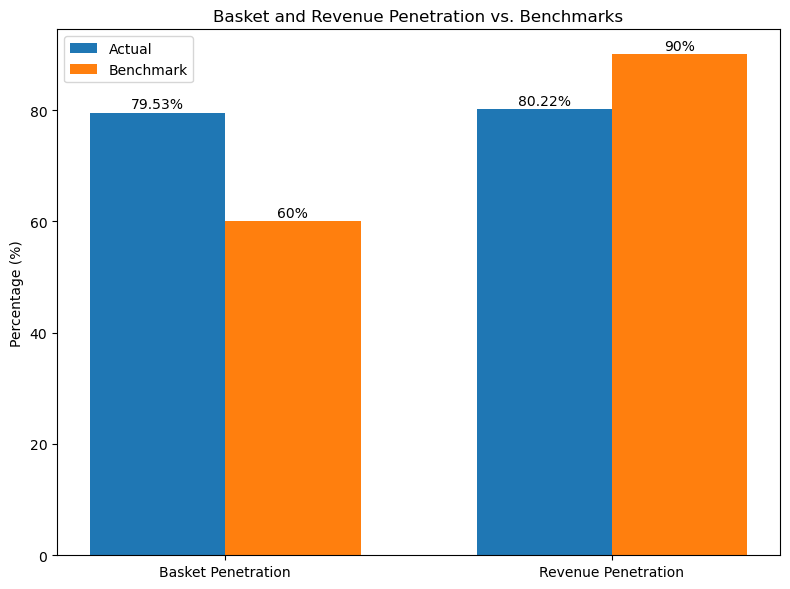

In [102]:
import matplotlib.pyplot as plt

# Data for visualization
categories = ['Basket Penetration', 'Revenue Penetration']
values = [79.53, 80.22]
benchmarks = [60, 90]

# Create the figure and axes
fig, ax = plt.subplots(figsize=(8, 6))

# Bar chart for actual values and benchmarks
bar_width = 0.35
x = range(len(categories))
bars_actual = ax.bar(x, values, bar_width, label='Actual', color='#1f77b4')
bars_benchmark = ax.bar([p + bar_width for p in x], benchmarks, bar_width, label='Benchmark', color='#ff7f0e')

# Add labels, title, and legend
ax.set_xticks([p + bar_width / 2 for p in x])
ax.set_xticklabels(categories)
ax.set_ylabel('Percentage (%)')
ax.set_title('Basket and Revenue Penetration vs. Benchmarks')
ax.legend()

# values
for bar in bars_actual:
    height = bar.get_height()
    ax.annotate(f'{height}%', xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3), textcoords='offset points', ha='center', fontsize=10)

for bar in bars_benchmark:
    height = bar.get_height()
    ax.annotate(f'{height}%', xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3), textcoords='offset points', ha='center', fontsize=10)

# Showing the plot
plt.tight_layout()
plt.show()


### Query to calculate the total issuance in 2007.
#### Calculate Base Points:

For each transaction by a loyalty member:
- Base Points =[spend / 10]

- Bonus Points = [0.1 * Base Points]

- Total Points Issued = Base Points+(0.1×Base Points)



In [38]:
query ="""

SELECT 
    SUM(FLOOR(spend / 10)) + SUM(FLOOR(spend / 10) * 0.1) AS total_issuance 
FROM 
    sales
WHERE 
    cust_code IS NOT NULL -- Only loyalty members
    AND shop_date BETWEEN '2007-01-01' AND '2007-12-31'; -- Filter for 2007

             """

query_result = pd.read_sql_query(query,conn)
query_result 

,total_issuance
0,24211.0


### Calculating the redemption rate:
- Redemption Rate = Points Redeemed/Points Issued *100
#### In this case, 
- Redemption Rate = 150000 / 24211 * 100
- Redemption Rate = 619.5%
- A redemption rate of 619.5% is impossibly high, meaning there’s likely an issue with how the issuance or redemption data is being interpreted or calculated.

### Querying the sales table to get the distinct count of loyalty members that made a purchase in 2007

In [33]:
query ="""

SELECT 
    COUNT(DISTINCT basket_id) AS distinct_transactions, COUNT(DISTINCT cust_code) AS distinct_loyalty_customers
FROM sales
WHERE cust_code IS not NULL
  AND shop_date BETWEEN '2007-01-01' AND '2007-12-31';


     """

query_result = pd.read_sql_query(query,conn)
query_result 

,distinct_transactions,distinct_loyalty_customers
0,175467,4192


#### From the provided information:

- Out of 4,192 customers who shopped in 2007, only 1,500 redeemed points.
- This implies 35.8% (1,500 ÷ 4,192 × 100) of customers who earned points actually redeemed them.

#### This clearly shows:

- A significant portion of redeemed points (likely the majority) must have come from carry-over points issued in previous years.

#### To estimate carry-over points:
- Carry-over Points Redeemed = Total Redeemed Points - Total Issuance in 2007
- Carry-over Points Redeemed = 150,000 - 24211
- Carry-over Points Redeemed = 125,789

#### Average Points Earned vs Redeemed per Customer:
- Average Points Earned per Customer: 24,211/4,192 = 5.78 points
- Average Points Redeemed per Customer: 150,000/1,500 = 100 points
##### The large gap suggest that customers who redeemed likely accumulated points over years


### Understanding the customer lifestages and how they behave

In [110]:
query ="""

SELECT 
    c.cust_lifestage,
    COUNT(DISTINCT s.cust_code) AS num_loyalty_customers, -- Number of customers in each lifestage
    SUM(FLOOR(spend / 10)) + SUM(FLOOR(spend / 10) * 0.1) AS total_points_earned, -- Points earning
    SUM(s.spend) AS total_spend, -- Overall spend
    ROUND(SUM(s.spend)/ COUNT(DISTINCT s.cust_code),2) AS Avg_spend_per_customer
FROM 
    sales s
JOIN 
    customers c
ON 
    s.cust_code = c.cust_code
WHERE 
    s.shop_date BETWEEN '2007-01-01' AND '2007-12-31'
GROUP BY 
    c.cust_lifestage
ORDER BY
    total_points_earned desc;
 """

query_result = pd.read_sql_query(query,conn)
query_result 

,CUST_LIFESTAGE,num_loyalty_customers,total_points_earned,total_spend,Avg_spend_per_customer
0,OT,1720,8839.6,677986.92,394.18
1,YF,518,4110.7,447500.70,863.90
2,None,448,3098.7,266424.52,594.70
3,OA,475,3067.9,254682.92,536.17
4,YA,567,2902.9,283204.19,499.48
5,PE,310,1129.7,122765.01,396.02
6,OF,154,1061.5,117856.59,765.30


### Dual Axis Plot: Total Spend and Points Earned by Segment

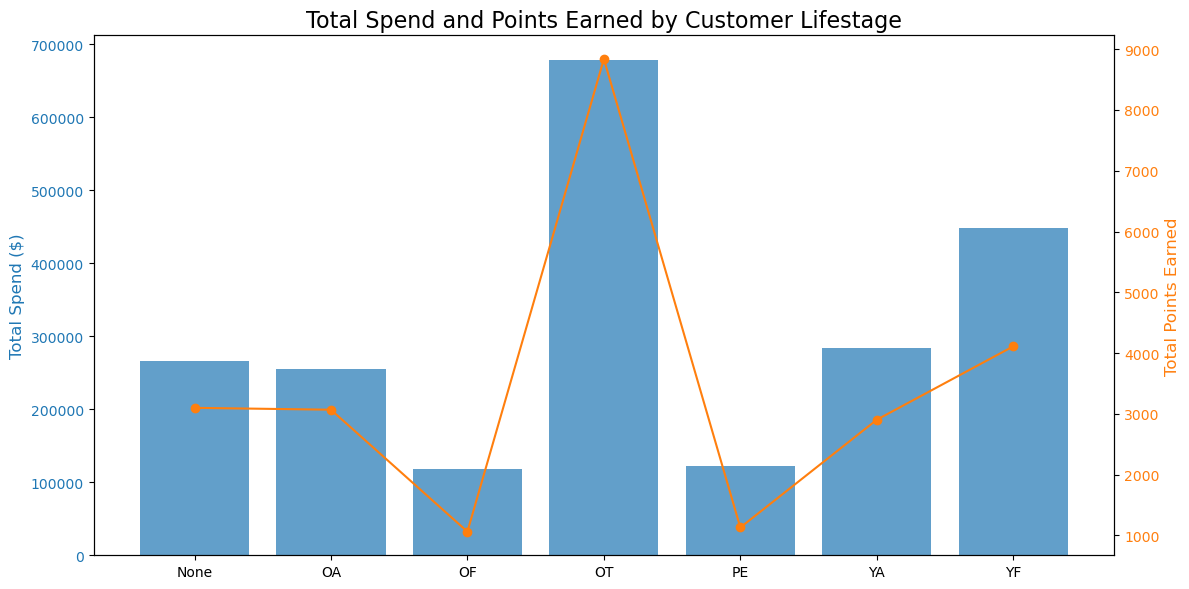

In [97]:
# Data from query results
data = {
    'CUST_LIFESTAGE': ['None', 'OA', 'OF', 'OT', 'PE', 'YA', 'YF'],
    'total_spend': [266424.52, 254682.92, 117856.59, 677986.92, 122765.01, 283204.19, 447500.70],
    'total_points_earned': [3098.7, 3067.9, 1061.5, 8839.6, 1129.7, 2902.9, 4110.7],
    'loyalty_customers' : [448, 475, 154, 1720, 310, 567, 518]
}
df = pd.DataFrame(data)

# Dual-axis bar plot
fig, ax1 = plt.subplots(figsize=(12, 6))

# total spend on the left y-axis
ax1.bar(df['CUST_LIFESTAGE'], df['total_spend'], color='#1f77b4', label='Total Spend', alpha=0.7)
ax1.set_ylabel('Total Spend ($)', fontsize=12, color='#1f77b4')
ax1.tick_params(axis='y', labelcolor='#1f77b4')

# Creating a second y-axis for points earned
ax2 = ax1.twinx()
ax2.plot(df['CUST_LIFESTAGE'], df['total_points_earned'], color='#ff7f0e', marker='o', label='Points Earned')
ax2.set_ylabel('Total Points Earned', fontsize=12, color='#ff7f0e')
ax2.tick_params(axis='y', labelcolor='#ff7f0e')

# title and legend
plt.title('Total Spend and Points Earned by Customer Lifestage', fontsize=16)
fig.tight_layout()
plt.show()


### Scatter Plot: Average Spend Per Customer vs. Segment Size

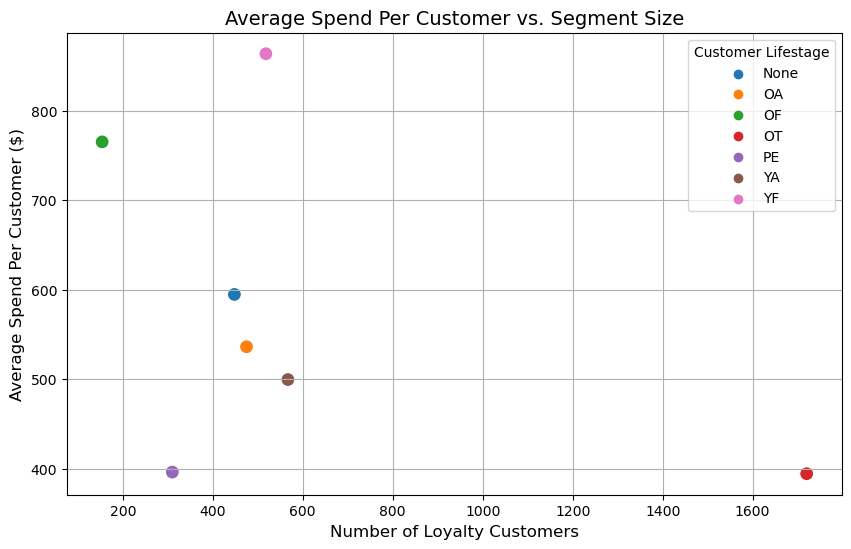

In [91]:

data = {
    'CUST_LIFESTAGE': ['None', 'OA', 'OF', 'OT', 'PE', 'YA', 'YF'],
    'total_spend': [266424.52, 254682.92, 117856.59, 677986.92, 122765.01, 283204.19, 447500.70],
    'total_points_earned': [3098.7, 3067.9, 1061.5, 8839.6, 1129.7, 2902.9, 4110.7]
}
df = pd.DataFrame(data)

# Calculating average spend per customer
df['avg_spend_per_customer'] = df['total_spend'] / [448, 475, 154, 1720, 310, 567, 518]

# Scatter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(x=[448, 475, 154, 1720, 310, 567, 518], y=df['avg_spend_per_customer'], hue=df['CUST_LIFESTAGE'], s=100)

# labels and title
plt.title('Average Spend Per Customer vs. Segment Size', fontsize=14)
plt.xlabel('Number of Loyalty Customers', fontsize=12)
plt.ylabel('Average Spend Per Customer ($)', fontsize=12)
plt.legend(title='Customer Lifestage')
plt.grid(True)
plt.show()


### Bar Chart: Loyalty Segment Composition

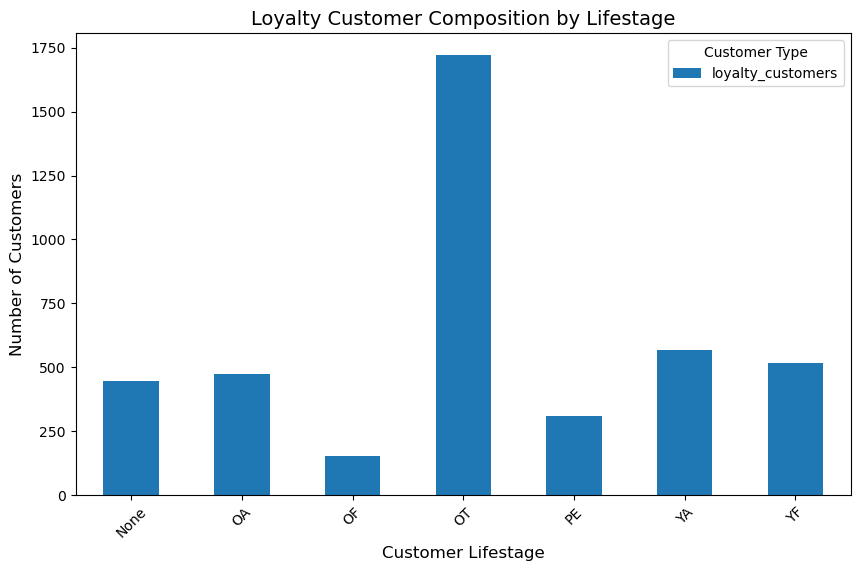

In [88]:
# Stacked bar data
df['loyalty_customers'] = [448, 475, 154, 1720, 310, 567, 518]


# Stacked bar plot
df[['CUST_LIFESTAGE', 'loyalty_customers']].set_index('CUST_LIFESTAGE').plot(
    kind='bar', figsize=(10, 6), color=['#1f77b4']
)

# labels and title
plt.title('Loyalty Customer Composition by Lifestage', fontsize=14)
plt.ylabel('Number of Customers', fontsize=12)
plt.xlabel('Customer Lifestage', fontsize=12)
plt.legend(title='Customer Type')
plt.xticks(rotation=45)
plt.show()


In [109]:
query ="""

SELECT 
    s.store_code,
    COUNT(DISTINCT s.cust_code) AS num_loyalty_customers, -- Number of customers in each lifestage
    SUM(FLOOR(spend / 10)) + SUM(FLOOR(spend / 10) * 0.1) AS total_points_earned, -- Points earning
    SUM(s.spend) AS total_spend, -- Overall spend
    ROUND(SUM(s.spend)/ COUNT(DISTINCT s.cust_code),2) AS Avg_spend_per_customer
FROM 
    sales s
JOIN 
    customers c
ON 
    s.cust_code = c.cust_code
WHERE 
    s.shop_date BETWEEN '2007-01-01' AND '2007-12-31'
GROUP BY 
    s.store_code
ORDER BY
    total_points_earned desc;
 """

query_result = pd.read_sql_query(query,conn)
query_result 

,STORE_CODE,num_loyalty_customers,total_points_earned,total_spend,Avg_spend_per_customer
0,W02,1054,2765.4,233095.77,221.15
1,S02,1097,2422.2,219218.40,199.83
2,E02,828,2338.6,167732.80,202.58
3,N01,1084,2241.8,217816.99,200.94
4,N03,1056,2065.8,195312.26,184.95
5,N02,977,2057.0,185226.66,189.59
6,W01,961,1989.9,168915.31,175.77
7,E03,793,1828.2,162287.69,204.65
8,S03,868,1780.9,167602.41,193.09
9,S01,900,1743.5,150664.04,167.40


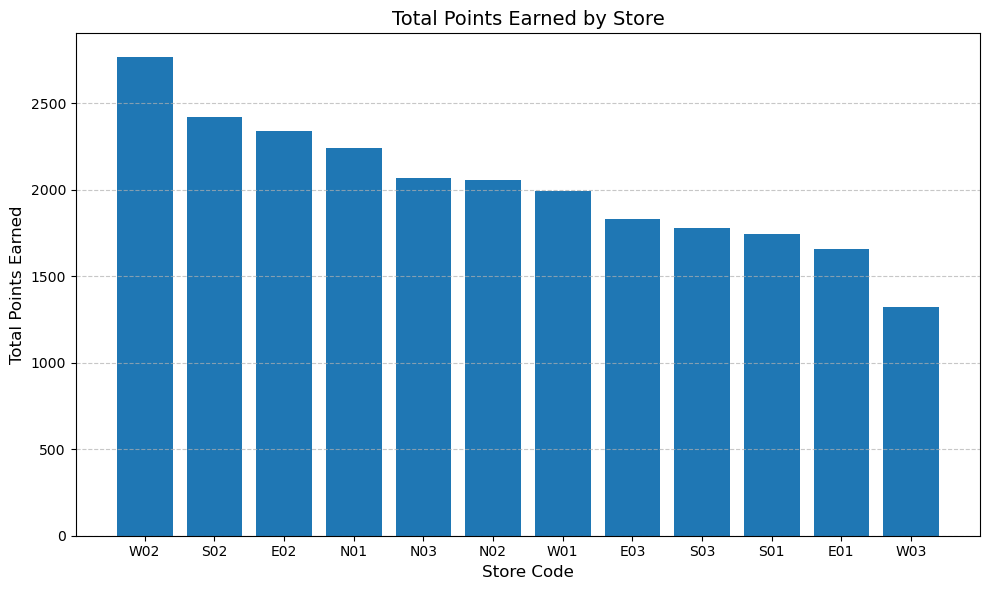

In [111]:
import matplotlib.pyplot as plt

# Data
data = {
    'STORE_CODE': ['W02', 'S02', 'E02', 'N01', 'N03', 'N02', 'W01', 'E03', 'S03', 'S01', 'E01', 'W03'],
    'total_points_earned': [2765.4, 2422.2, 2338.6, 2241.8, 2065.8, 2057.0, 1989.9, 1828.2, 1780.9, 1743.5, 1656.6, 1321.1]
}

# Bar chart
plt.figure(figsize=(10, 6))
plt.bar(data['STORE_CODE'], data['total_points_earned'], color='#1f77b4')
plt.title('Total Points Earned by Store', fontsize=14)
plt.xlabel('Store Code', fontsize=12)
plt.ylabel('Total Points Earned', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


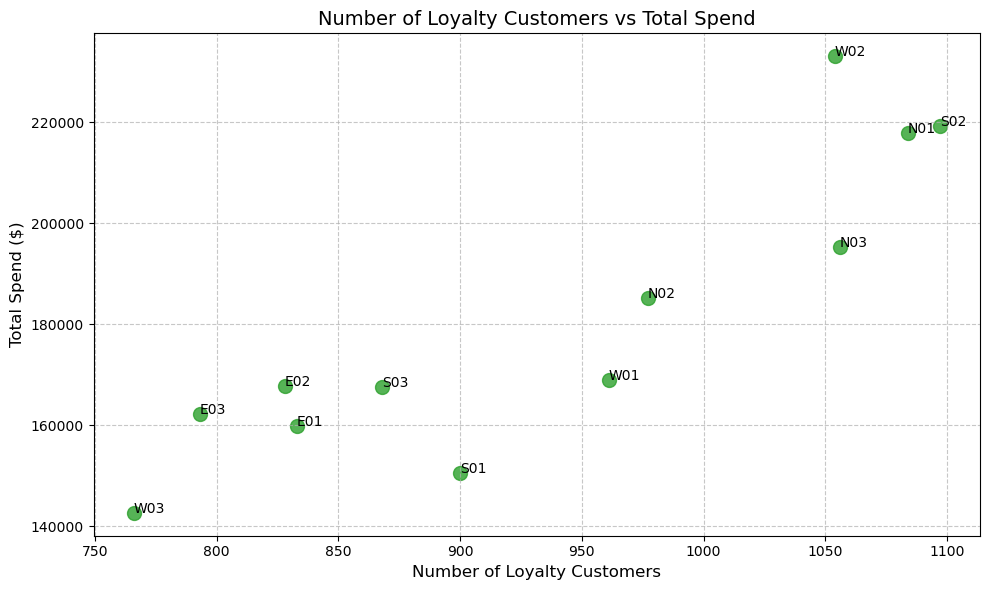

In [113]:
# Data
data = {
    'STORE_CODE': ['W02', 'S02', 'E02', 'N01', 'N03', 'N02', 'W01', 'E03', 'S03', 'S01', 'E01', 'W03'],
    'num_loyalty_customers': [1054, 1097, 828, 1084, 1056, 977, 961, 793, 868, 900, 833, 766],
    'total_spend': [233095.77, 219218.40, 167732.80, 217816.99, 195312.26, 185226.66, 168915.31, 162287.69, 167602.41, 150664.04, 159853.92, 142694.60]
}

# Scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(data['num_loyalty_customers'], data['total_spend'], color='#2ca02c', s=100, alpha=0.8)
for i, txt in enumerate(data['STORE_CODE']):
    plt.annotate(txt, (data['num_loyalty_customers'][i], data['total_spend'][i]), fontsize=10)
plt.title('Number of Loyalty Customers vs Total Spend', fontsize=14)
plt.xlabel('Number of Loyalty Customers', fontsize=12)
plt.ylabel('Total Spend ($)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


### Store E01 Promotional Analysis
#### Since the data only goes up to 2008-07-06, I simulated the promotional analysis by using an earlier period with the same structure. The approach is as follows:

- Simulated Promotion Period: I used June 2008 as the "promotion period" for Berlin store (E01).
- Pre-Promotion Period: I used May 2008 as the period before the promotion.
- Control Market: I used the Budapest store (E03) for the same months (May and June 2008) to act as the control, as it did not run the promotion.
- This adjustment allows us to evaluate the potential impact of a similar promotion using historical data.



In [8]:
query ="""
SELECT *
FROM sales
WHERE store_code = 'E01'
  AND shop_date BETWEEN '2008-06-01' AND '2008-06-30';
"""

query_result = pd.read_sql_query(query,conn)
query_result 

,CUST_CODE,PROD_CODE,SPEND,QUANTITY,BASKET_ID,STORE_CODE,SHOP_DATE
0,CUST0000508514,PRD0904962,6.27,3,994111200498487,E01,2008-06-01
1,None,PRD0902429,0.87,1,994111200062995,E01,2008-06-01
2,CUST0000365429,PRD0902787,2.03,1,994116401215716,E01,2008-06-01
3,CUST0000817991,PRD0903052,0.71,1,994111200699716,E01,2008-06-01
4,CUST0000139484,PRD0903767,1.68,3,994111200259711,E01,2008-06-01
...,...,...,...,...,...,...,...
10090,CUST0000701603,PRD0903879,3.37,1,994111700623928,E01,2008-06-30
10091,CUST0000274139,PRD0903075,1.39,1,994111700346544,E01,2008-06-30
10092,CUST0000379903,PRD0903320,1.72,1,994122001223565,E01,2008-06-30
10093,CUST0000622126,PRD0904502,1.20,1,994111700571913,E01,2008-06-30


#### Querying the data for the promotion period (June). Comparing the E01 and E03 stores

In [54]:
query ="""
SELECT 
    store_code,
    SUM(spend) AS total_revenue,
    COUNT(DISTINCT basket_id) AS total_transactions,
    ROUND(AVG(spend),2) AS avg_spend,
    COUNT(DISTINCT CASE WHEN cust_code IS NOT NULL THEN cust_code END) AS loyalty_customers,
    COUNT(DISTINCT CASE WHEN cust_code IS NULL THEN basket_id END) AS non_loyalty_customers
FROM sales
WHERE store_code IN ('E01', 'E03')
  AND shop_date BETWEEN '2008-06-01' AND '2008-06-30'
GROUP BY store_code;
"""
query_result = pd.read_sql_query(query,conn)
query_result

,STORE_CODE,total_revenue,total_transactions,avg_spend,loyalty_customers,non_loyalty_customers
0,E01,18839.72,3173,1.87,690,663
1,E03,16496.41,1314,1.91,353,270


#### Pre-promotional period comparison for both stores using the month of May data.

In [55]:
query ="""
SELECT 
    store_code,
    SUM(spend) AS total_revenue,
    COUNT(DISTINCT basket_id) AS total_transactions,
    ROUND(AVG(spend),2) AS avg_spend,
    COUNT(DISTINCT CASE WHEN cust_code IS NOT NULL THEN cust_code END) AS loyalty_customers,
    COUNT(DISTINCT CASE WHEN cust_code IS NULL THEN basket_id END) AS non_loyalty_customers
FROM sales
WHERE store_code IN ('E01', 'E03')
  AND shop_date BETWEEN '2008-05-01' AND '2008-05-30'
GROUP BY store_code;
"""
query_result = pd.read_sql_query(query,conn)
query_result

,STORE_CODE,total_revenue,total_transactions,avg_spend,loyalty_customers,non_loyalty_customers
0,E01,16515.94,1405,1.86,357,261
1,E03,15717.20,1300,1.88,349,268


#### Looking into the previous year analysis for the month of June (2007) 

In [30]:
query ="""
SELECT 
    store_code,
    SUM(spend) AS total_revenue,
    COUNT(DISTINCT basket_id) AS total_transactions,
    ROUND(AVG(spend),2) AS avg_spend,
    COUNT(DISTINCT CASE WHEN cust_code IS NOT NULL THEN cust_code END) AS loyalty_customers,
    COUNT(DISTINCT CASE WHEN cust_code IS NULL THEN basket_id END) AS non_loyalty_customers
FROM sales
WHERE store_code IN ('E01', 'E03')
  AND shop_date BETWEEN '2007-06-01' AND '2007-06-30'
GROUP BY store_code;
"""
query_result = pd.read_sql_query(query,conn)
query_result

,STORE_CODE,total_revenue,total_transactions,avg_spend,loyalty_customers,non_loyalty_customers
0,E01,17363.23,1429,1.89,317,316
1,E03,17301.02,1368,1.94,286,267


#### June 2006 analysis, this is to understand seasonality

In [32]:
query ="""
SELECT 
    store_code,
    SUM(spend) AS total_revenue,
    COUNT(DISTINCT basket_id) AS total_transactions,
    ROUND(AVG(spend),2) AS avg_spend,
    COUNT(DISTINCT CASE WHEN cust_code IS NOT NULL THEN cust_code END) AS loyalty_customers,
    COUNT(DISTINCT CASE WHEN cust_code IS NULL THEN basket_id END) AS non_loyalty_customers
FROM sales
WHERE store_code IN ('E01', 'E03')
  AND shop_date BETWEEN '2006-06-01' AND '2006-06-30'
GROUP BY store_code;
"""
query_result = pd.read_sql_query(query,conn)
query_result

,STORE_CODE,total_revenue,total_transactions,avg_spend,loyalty_customers,non_loyalty_customers
0,E01,16723.73,1401,1.86,298,276
1,E03,17478.05,1310,1.93,306,261


### Comparing the pre and promotion analysis metrics for store E01

#### Promotion Store (E01):
##### Revenue Growth: 
   - Incremental Revenue = 18,839.72 − 16,515.94 = 2,323.78
   - Revenue increased by $2,323.78 during the promotion period.

##### Transaction Growth:
   - Incremental transaction = 3,173 − 1,405 = 1,768
   - Transactions more than doubled, indicating that the promotion significantly increased customer activity.

##### Average Spend:

   - Pre-Promotion: $1.86
   - Post-Promotion: $1.87
   - Not so significant increase, suggesting the promotion encouraged more transactions but didn’t significantly boost spending per basket.

##### Loyalty vs. Non-Loyalty Customers:

   - Loyalty customers increased from 357 to 690 (+333).
   - Non-loyalty customers increased from 261 to 663 (+402).
   - The promotion attracted both loyalty and non-loyalty customers, with slightly more growth among non-loyalty customers.

### Comparing the control (E03) store's pre and post promotion analysis

##### Revenue Growth:
   - Incremental Revenue (E03) = 16,496.41 − 15,717.20 = 779.21
   - Revenue grew by $779.21, likely due to seasonal factors.

##### Transaction Growth:
   - Incremental Transactions (E03) = 1,314 − 1,300 = 14
   - Minimal increase, indicating no significant changes in customer activity.

##### Average Spend:
   - Pre-promotion: $1.88
   - Post-promotion: $1.91
   - Slight increase in spend per basket.

##### Loyalty vs. Non-Loyalty Customers:

   - Loyalty customers increased by 4 (from 349 to 353).
   - Non-loyalty customers increased by 2 (from 268 to 270).
   - No meaningful change in customer activity.


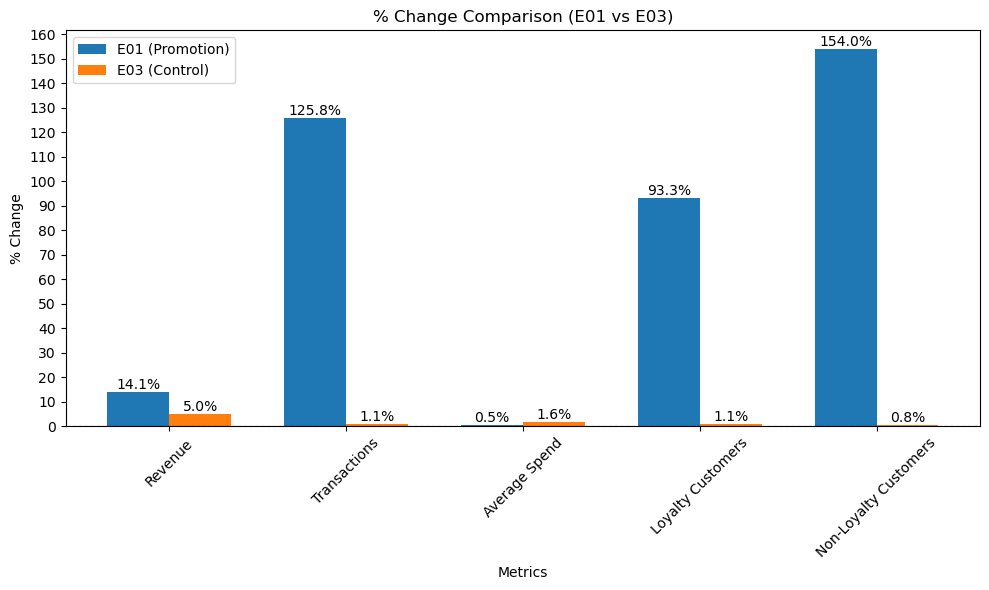

In [28]:
import matplotlib.pyplot as plt
import numpy as np

# Data preparation
metrics = ['Revenue', 'Transactions', 'Average Spend', 'Loyalty Customers', 'Non-Loyalty Customers']
e01_changes = [14.06, 125.83, 0.54, 93.28, 154.00]  # % changes for E01
e03_changes = [4.96, 1.08, 1.60, 1.15, 0.75]  # % changes for E03

# X-axis positions
x = np.arange(len(metrics))  # positions for the metrics
width = 0.35  # width of each bar

# Create the plot with adjusted dimensions
plt.figure(figsize=(14, 8))  # Increase figure size for longer bars
bars1 = plt.bar(x - width/2, e01_changes, width, label='E01 (Promotion)', color='#1f77b4')
bars2 = plt.bar(x + width/2, e03_changes, width, label='E03 (Control)', color='#ff7f0e')

# Add labels and title
plt.ylabel('% Change', fontsize=12)
plt.xlabel('Metrics', fontsize=12)
plt.title('% Change Comparison (E01 vs E03)', fontsize=14)
plt.xticks(ticks=x, labels=metrics, rotation=45, fontsize=10)
plt.axhline(0, color='black', linewidth=0.8, linestyle='--')  # Add a horizontal line at 0
plt.legend(fontsize=12)

# Set y-axis ticks with increments of 10
plt.yticks(np.arange(0, 170, 10), fontsize=10)  # From 0 to 160 with steps of 10

# Add bar labels for E01
for bar in bars1:
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height(), f'{bar.get_height():.1f}%', 
             ha='center', va='bottom', fontsize=10)

# Add bar labels for E03
for bar in bars2:
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height(), f'{bar.get_height():.2f}%', 
             ha='center', va='bottom', fontsize=10)

# Tight layout to avoid overlap
plt.tight_layout()

# Show the plot
plt.show()


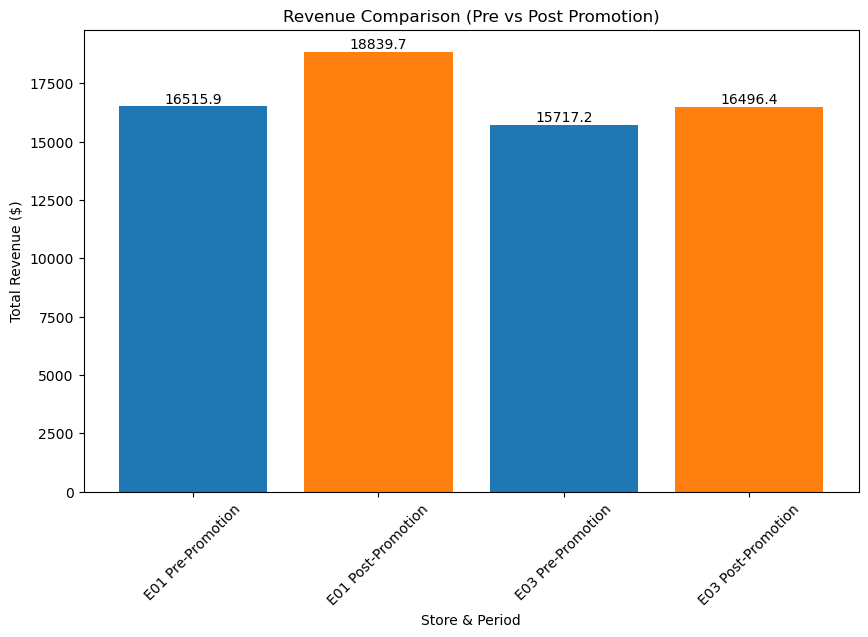

In [68]:
data = {
    'Store': ['E01', 'E01', 'E03', 'E03'],
    'Period': ['Pre-Promotion', 'Post-Promotion', 'Pre-Promotion', 'Post-Promotion'],
    'Revenue': [16515.94, 18839.72, 15717.20, 16496.41]
}
df = pd.DataFrame(data)

# Bar plot
plt.figure(figsize=(10, 6))
bars = plt.bar(df['Store'] + " " + df['Period'], df['Revenue'], color=['#1f77b4', '#ff7f0e', '#1f77b4', '#ff7f0e'])
plt.title('Revenue Comparison (Pre vs Post Promotion)')
plt.ylabel('Total Revenue ($)')
plt.xlabel('Store & Period')
plt.xticks(rotation=45)
plt.bar_label(bars)
plt.show()

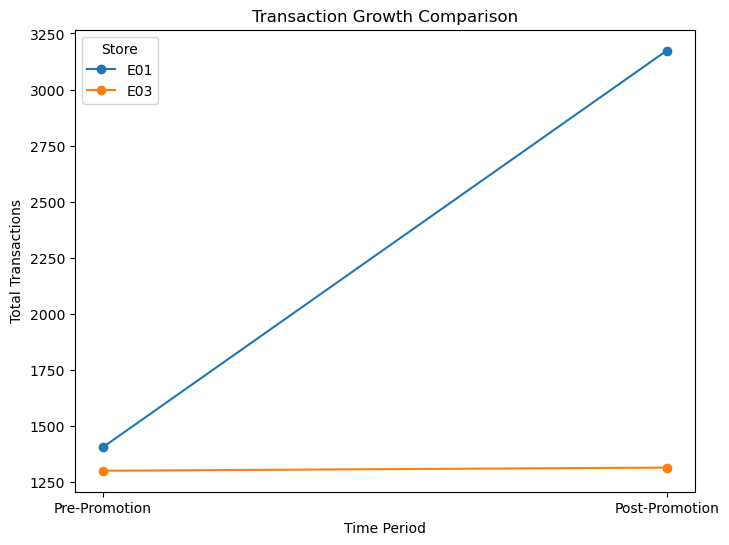

In [61]:
data = {
    'Store': ['E01', 'E01', 'E03', 'E03'],
    'Period': ['Pre-Promotion', 'Promotion', 'Pre-Promotion', 'Promotion'],
    'Transactions': [1405, 3173, 1300, 1314],
    'Average Spend': [1.86, 1.87, 1.88, 1.91],
    'Revenue': [16515.94,18839.72,15717.20,16496.41],
    'Loyal Customers': [357,690,349,353],
    'Non_Loyal': [261,663,268,270]

}
df = pd.DataFrame(data)

# Line Plot
plt.figure(figsize=(8, 6))
for store in df['Store'].unique():
    store_data = df[df['Store'] == store]
    plt.plot(store_data['Period'], store_data['Transactions'], marker='o', label=store)

plt.title('Transaction Growth Comparison')
plt.ylabel('Total Transactions')
plt.xlabel('Time Period')
plt.legend(title='Store')
plt.show()


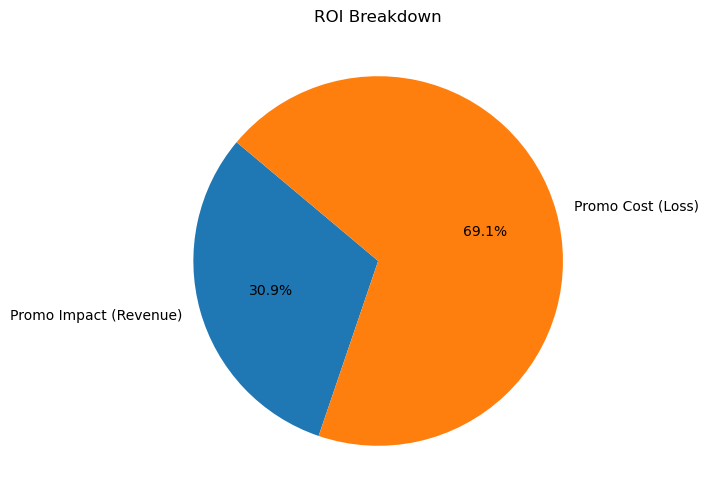

In [114]:
labels = ['Promo Impact (Revenue)', 'Promo Cost (Loss)']
values = [1544.57, 5000 - 1544.57]
colors = ['#1f77b4', '#ff7f0e']

plt.figure(figsize=(6, 6))
plt.pie(values, labels=labels, autopct='%1.1f%%', colors=colors, startangle=140)
plt.title('ROI Breakdown')
plt.show()


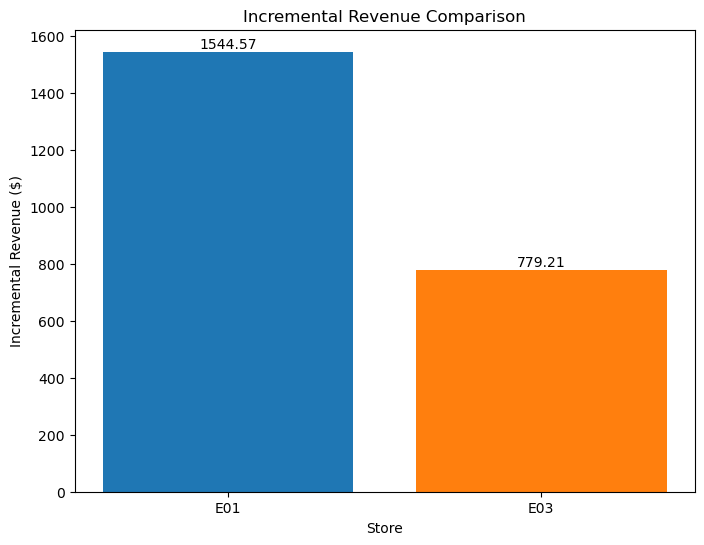

In [66]:
data = {
    'Store': ['E01', 'E03'],
    'Incremental_Revenue': [1544.57, 779.21]
}
df = pd.DataFrame(data)

plt.figure(figsize=(8, 6))
bars = plt.bar(df['Store'], df['Incremental_Revenue'], color=['#1f77b4', '#ff7f0e'])
plt.title('Incremental Revenue Comparison')
plt.ylabel('Incremental Revenue ($)')
plt.xlabel('Store')
plt.bar_label(bars)
plt.show()


#### Categorizing the promotion impact by the customer lifestage

In [26]:
query ="""

SELECT 
    c.cust_lifestage,
    s.store_code,
    SUM(s.spend) AS total_revenue,
    COUNT(DISTINCT s.basket_id) AS total_transactions,
    ROUND(AVG(s.spend),2) AS avg_spend,
    COUNT(DISTINCT CASE WHEN s.cust_code IS NOT NULL THEN s.cust_code END) AS loyalty_customers
FROM
    sales s
JOIN 
    customers c
ON 
    s.cust_code = c.cust_code
WHERE 
    s.store_code IN ('E01', 'E03') AND
    s.shop_date BETWEEN '2008-05-01' AND '2008-05-30'
GROUP BY 
    c.cust_lifestage, s.store_code
;
 """

query_result = pd.read_sql_query(query,conn)
query_result 

,CUST_LIFESTAGE,STORE_CODE,total_revenue,total_transactions,avg_spend,loyalty_customers
0,None,E01,1798.31,170,1.92,47
1,None,E03,1624.58,147,1.80,50
2,OA,E01,1194.39,110,1.83,35
3,OA,E03,1553.28,150,1.96,43
4,OF,E01,934.68,68,1.80,20
5,OF,E03,262.03,20,2.08,11
6,OT,E01,3407.95,294,1.93,116
7,OT,E03,4654.98,347,1.98,117
8,PE,E01,767.37,95,1.50,20
9,PE,E03,734.29,79,1.55,28


In [27]:
query ="""

SELECT 
    c.cust_lifestage,
    s.store_code,
    SUM(s.spend) AS total_revenue,
    COUNT(DISTINCT s.basket_id) AS total_transactions,
    ROUND(AVG(s.spend),2) AS avg_spend,
    COUNT(DISTINCT CASE WHEN c.cust_code IS NOT NULL THEN c.cust_code END) AS loyalty_customers
FROM
    sales s
JOIN 
    customers c
ON 
    s.cust_code = c.cust_code
WHERE 
    s.store_code IN ('E01', 'E03') AND
    s.shop_date BETWEEN '2008-06-01' AND '2008-06-30'
GROUP BY 
    c.cust_lifestage, s.store_code
;
 """

query_result = pd.read_sql_query(query,conn)
query_result 

,CUST_LIFESTAGE,STORE_CODE,total_revenue,total_transactions,avg_spend,loyalty_customers
0,None,E01,1946.80,318,1.87,84
1,None,E03,1907.03,164,1.78,51
2,OA,E01,1452.90,257,1.76,72
3,OA,E03,1957.81,181,1.78,46
4,OF,E01,967.96,137,2.05,32
5,OF,E03,222.71,22,1.71,13
6,OT,E01,3984.26,721,1.86,228
7,OT,E03,4898.81,330,1.95,118
8,PE,E01,1042.52,200,1.71,47
9,PE,E03,973.66,78,2.11,25
